In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm, skew
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
sns.set(style='white', context='notebook', palette='deep')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ml-dataset/train.csv
/kaggle/input/ml-dataset/test.csv
/kaggle/input/ml-dataset/sample_submission.csv
/kaggle/input/fare-classification/meta_data.csv


In [2]:
train = pd.read_csv("../input/ml-dataset/train.csv")
test = pd.read_csv("../input/ml-dataset/test.csv")
IDtest = test["tripid"]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

In [4]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [6]:
Outliers_to_drop = detect_outliers(train,2,["additional_fare","duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup"
                                           ,"pick_lat","pick_lon","drop_lat","drop_lon"])

In [7]:
train.loc[Outliers_to_drop]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
25,189160756,10.5,358.0,66.0,0.0000,79.0,11/1/2019 8:51,11/1/2019 8:57,6.05858,80.2003,6.05566,80.1810,210.58,incorrect
34,189164791,10.5,286.0,44.0,0.0000,9.0,11/1/2019 9:23,11/1/2019 9:28,7.48628,80.6206,7.47984,80.6233,545.89,incorrect
51,189182800,10.5,220.0,10.0,0.0000,27.0,11/1/2019 11:34,11/1/2019 11:37,7.48995,80.3639,7.49838,80.3715,71.84,correct
84,189227008,10.5,2159.0,1158.0,67.5114,344.0,11/1/2019 14:31,11/1/2019 15:07,7.32514,80.6521,7.29959,80.6366,274.56,correct
115,189250944,10.5,1301.0,10.0,0.0000,60.0,11/1/2019 16:43,11/1/2019 17:05,7.31738,80.6995,7.33181,80.6289,356.51,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16751,213125070,10.5,1748.0,80.0,0.0000,37.0,1/29/2020 20:42,1/29/2020 21:11,7.29311,80.6370,7.33452,80.6823,431.96,correct
16944,213372335,10.5,300.0,1.0,0.0583,66.0,1/30/2020 17:48,1/30/2020 17:53,7.30790,80.6371,7.32106,80.6387,99.53,correct
16966,213397557,30.5,777.0,54.0,0.0000,128.0,1/30/2020 18:53,1/30/2020 19:06,7.29334,80.6361,7.32462,80.6355,239.43,correct
17037,213521569,10.5,659.0,40.0,0.0000,87.0,1/31/2020 10:39,1/31/2020 10:50,7.29424,80.6335,7.32501,80.6311,177.47,correct


In [8]:
# train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
train.shape

(17176, 14)

In [10]:
# train_len = len(train)
# dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [11]:
# dataset = dataset.fillna(np.nan)

# # Check for Null values
# dataset.isnull().sum()

In [12]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

In [13]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [14]:
train.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object

In [15]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000


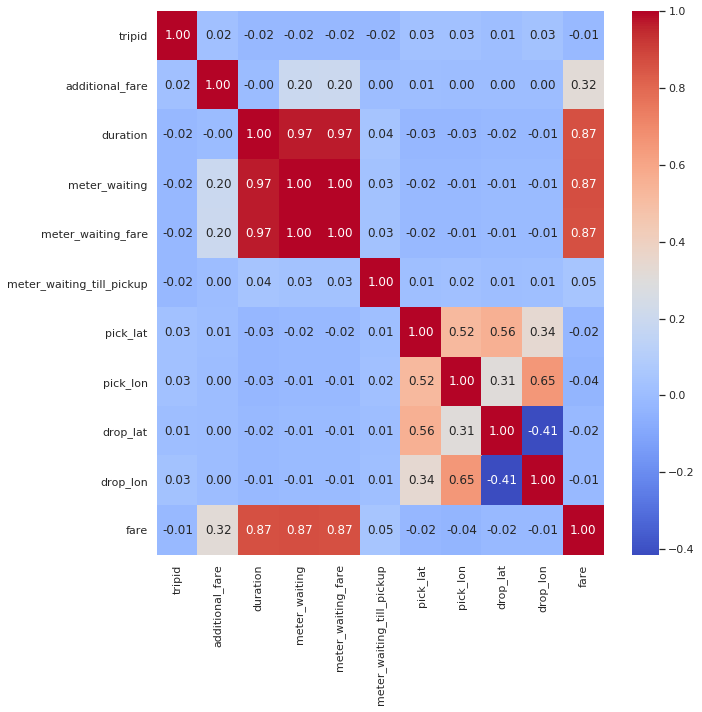

In [16]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [17]:
train['label'].value_counts()

correct      15495
incorrect     1681
Name: label, dtype: int64

In [18]:
train["pickup"] = pd.to_datetime(train["pickup_time"])
train["drop"] = pd.to_datetime(train["drop_time"])
train ['difference'] = train["drop"] - train["pickup"]
train ['difference'] = train ['difference']/np.timedelta64(1,'s')
# train_df['duration'] = train_df['duration'].fillna(train_df ['difference'])
train['travel_time'] = train['duration'] - train['meter_waiting']

#train_df['duration'] = train_df ['difference']
train['time'] = np.where(abs(train['duration']-train['difference']) > 120, train['difference'], train['duration'])

In [19]:
train = train[train.travel_time>=0]

In [20]:
train.shape

(16970, 19)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16970 entries, 0 to 17175
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tripid                     16970 non-null  int64         
 1   additional_fare            16970 non-null  float64       
 2   duration                   16970 non-null  float64       
 3   meter_waiting              16970 non-null  float64       
 4   meter_waiting_fare         16970 non-null  float64       
 5   meter_waiting_till_pickup  16970 non-null  float64       
 6   pickup_time                16970 non-null  object        
 7   drop_time                  16970 non-null  object        
 8   pick_lat                   16970 non-null  float64       
 9   pick_lon                   16970 non-null  float64       
 10  drop_lat                   16970 non-null  float64       
 11  drop_lon                   16970 non-null  float64       
 12  fare

# Remove Nan

In [22]:
train[( train['meter_waiting'].isnull() & train['meter_waiting_fare'].isnull() 
         & train['additional_fare'].isnull() & train['duration'].isnull() & train['meter_waiting_till_pickup'].isnull() )].shape

(0, 19)

In [23]:
train = train.drop(train[( train['meter_waiting'].isnull() & train['meter_waiting_fare'].isnull() 
         & train['additional_fare'].isnull() & train['duration'].isnull() & train['meter_waiting_till_pickup'].isnull() )].index, axis = 0).reset_index(drop=True)

In [24]:
train[( train['meter_waiting'].isnull() | train['fare'].isnull() )]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time
19,189157607,10.5,2956.0,1686.0,97.450800,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,incorrect,2019-11-01 08:40:00,2019-11-01 09:21:00,2460.0,1270.0,2460.0
29,189164806,10.5,3549.0,2689.0,146.985400,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,incorrect,2019-11-01 09:16:00,2019-11-01 09:29:00,780.0,860.0,780.0
1909,191263471,5.0,39.0,19.0,1.107700,0.0,11/11/2019 11:00,11/11/2019 11:09,6.93940,79.8756,6.93693,79.8641,NaN,incorrect,2019-11-11 11:00:00,2019-11-11 11:09:00,540.0,20.0,540.0
2678,192182656,5.0,23.0,23.0,1.340900,0.0,11/15/2019 14:31,11/15/2019 14:35,6.87287,79.8908,6.87959,79.8911,NaN,incorrect,2019-11-15 14:31:00,2019-11-15 14:35:00,240.0,0.0,240.0
11797,206984071,10.5,1585.0,833.0,48.147400,169.0,1/4/2020 15:05,1/4/2020 15:18,6.91742,79.8550,6.93338,79.8548,NaN,incorrect,2020-01-04 15:05:00,2020-01-04 15:18:00,780.0,752.0,780.0
13382,209203396,10.5,2423.0,1905.0,110.162896,23.0,1/13/2020 13:03,1/13/2020 13:15,6.91742,79.8550,6.92723,79.8452,NaN,incorrect,2020-01-13 13:03:00,2020-01-13 13:15:00,720.0,518.0,720.0


In [25]:
train[( train['fare'].isnull() )]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time
19,189157607,10.5,2956.0,1686.0,97.450800,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,incorrect,2019-11-01 08:40:00,2019-11-01 09:21:00,2460.0,1270.0,2460.0
29,189164806,10.5,3549.0,2689.0,146.985400,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,incorrect,2019-11-01 09:16:00,2019-11-01 09:29:00,780.0,860.0,780.0
1909,191263471,5.0,39.0,19.0,1.107700,0.0,11/11/2019 11:00,11/11/2019 11:09,6.93940,79.8756,6.93693,79.8641,NaN,incorrect,2019-11-11 11:00:00,2019-11-11 11:09:00,540.0,20.0,540.0
2678,192182656,5.0,23.0,23.0,1.340900,0.0,11/15/2019 14:31,11/15/2019 14:35,6.87287,79.8908,6.87959,79.8911,NaN,incorrect,2019-11-15 14:31:00,2019-11-15 14:35:00,240.0,0.0,240.0
11797,206984071,10.5,1585.0,833.0,48.147400,169.0,1/4/2020 15:05,1/4/2020 15:18,6.91742,79.8550,6.93338,79.8548,NaN,incorrect,2020-01-04 15:05:00,2020-01-04 15:18:00,780.0,752.0,780.0
13382,209203396,10.5,2423.0,1905.0,110.162896,23.0,1/13/2020 13:03,1/13/2020 13:15,6.91742,79.8550,6.92723,79.8452,NaN,incorrect,2020-01-13 13:03:00,2020-01-13 13:15:00,720.0,518.0,720.0


In [26]:
train= train.drop(train[( train['fare'].isnull() )].index, axis = 0).reset_index(drop=True)

In [27]:
train.isnull().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
pickup                       0
drop                         0
difference                   0
travel_time                  0
time                         0
dtype: int64

In [28]:
train['label'].value_counts()

correct      15441
incorrect     1523
Name: label, dtype: int64

In [29]:
train.shape

(16964, 19)

In [30]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,2019-11-01 00:20:00,2019-11-01 00:34:00,840.0,778.0,834.0
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,2019-11-01 00:56:00,2019-11-01 01:09:00,780.0,744.0,791.0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,2019-11-01 01:08:00,2019-11-01 01:26:00,1080.0,1007.0,1087.0
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,2019-11-01 02:27:00,2019-11-01 02:37:00,600.0,327.0,598.0
4,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,2019-11-01 05:38:00,2019-11-01 06:35:00,3420.0,3225.0,3407.0


In [31]:
train['distance'] = np.sqrt((abs(train['pick_lat']- train['drop_lat'])**2) + (abs(train['pick_lon']- train['drop_lon'])**2))

In [32]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time,distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,2019-11-01 00:20:00,2019-11-01 00:34:00,840.0,778.0,834.0,0.045869
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,2019-11-01 00:56:00,2019-11-01 01:09:00,780.0,744.0,791.0,0.028500
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,2019-11-01 01:08:00,2019-11-01 01:26:00,1080.0,1007.0,1087.0,0.057019
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,2019-11-01 02:27:00,2019-11-01 02:37:00,600.0,327.0,598.0,0.007806
4,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,2019-11-01 05:38:00,2019-11-01 06:35:00,3420.0,3225.0,3407.0,0.217734


# Removing outliers

****Fare****

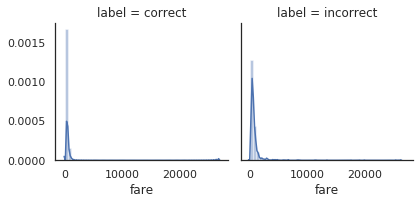

In [33]:
g = sns.FacetGrid(train, col='label')
g = g.map(sns.distplot, "fare")

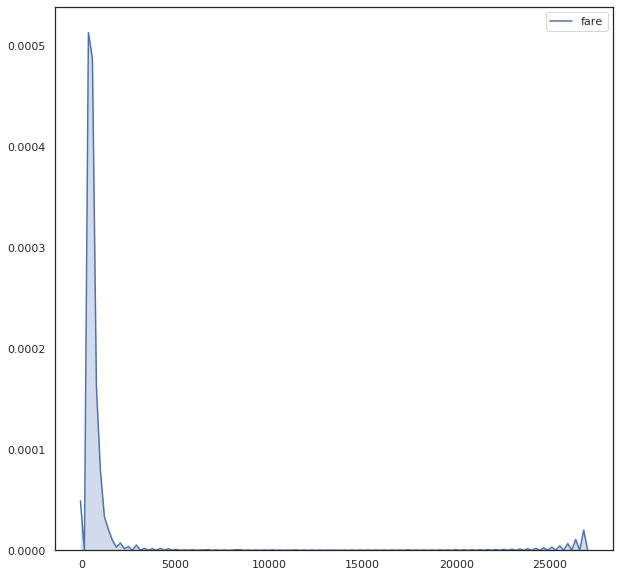

In [34]:
plt.figure(figsize=[10,10])
sns.kdeplot(train['fare'], shade=True);

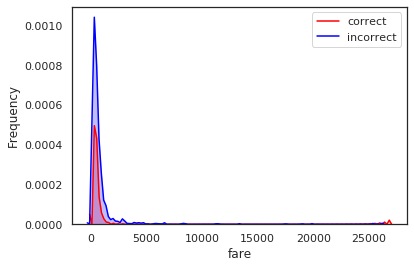

In [35]:
g = sns.kdeplot(train["fare"][(train["label"] == "correct") & (train["fare"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["fare"][(train["label"] == "incorrect") & (train["fare"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("fare")
g.set_ylabel("Frequency")
g = g.legend(["correct","incorrect"])


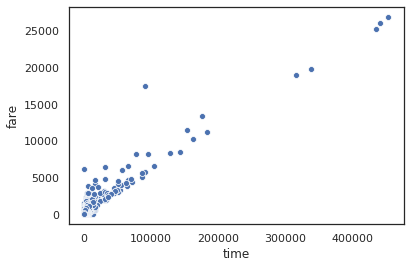

In [36]:
sns.scatterplot(x="time", y="fare", data=train)

two clear outliers

In [37]:
train[train.fare>15000].shape

(6, 20)

In [38]:
train = train[train.fare<15000]

In [39]:
# train[(train['fare']>15000)]

these two in train set

In [40]:
# train=train[(train['fare']<15000)]

In [41]:
train=train[train.meter_waiting_till_pickup < 4000]

In [42]:
train.shape

(16951, 20)

In [43]:
# train = train.drop(train[(train['fare']>15000) & (train['duration']<110000)].index, axis = 0).reset_index(drop=True)

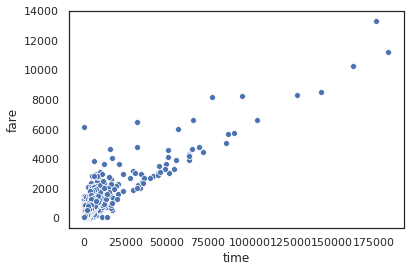

In [44]:
sns.scatterplot(x="time", y="fare", data=train)

In [45]:
train = train[train.time < 300000]

In [46]:
# train[(train['fare']>5000) & (train['duration']<1000)]

remove or not ?

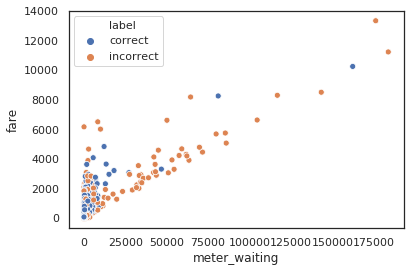

In [47]:
sns.scatterplot(x="meter_waiting", y="fare", hue="label",data=train)

two outlier (it may remove from above)

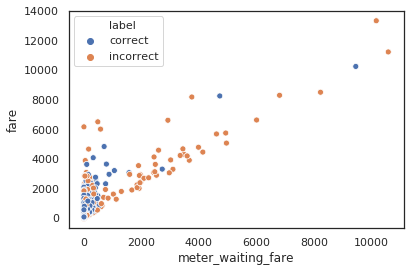

In [48]:
sns.scatterplot(x="meter_waiting_fare", y="fare", hue="label",data=train)

In [49]:
train[(train['fare'] < train['meter_waiting_fare'])]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time,distance


In [50]:
train['fare'].isnull().sum()

0

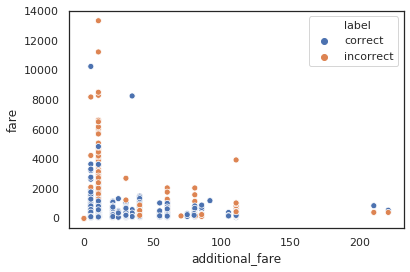

In [51]:
sns.scatterplot(x="additional_fare", y="fare", hue="label",data=train)

In [52]:
train[(train['fare'] < train['additional_fare'])]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time,distance
9946,203757140,110.5,521.0,80.0,4.653641,67.0,12/24/2019 17:07,12/24/2019 17:15,7.29295,80.637,7.28589,80.6319,77.51,correct,2019-12-24 17:07:00,2019-12-24 17:15:00,480.0,441.0,521.0,0.008709


In [53]:
# train = train.drop(train[(train['fare'] < train['additional_fare'])].index, axis = 0).reset_index(drop=True)

In [54]:
train[(train['fare'] < train['additional_fare'] + train['meter_waiting_fare'])]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time,distance
9946,203757140,110.5,521.0,80.0,4.653641,67.0,12/24/2019 17:07,12/24/2019 17:15,7.29295,80.637,7.28589,80.6319,77.51,correct,2019-12-24 17:07:00,2019-12-24 17:15:00,480.0,441.0,521.0,0.008709


In [55]:
train = train[train.additional_fare<200]

In [56]:
train.shape

(16947, 20)

this is test set. meter_waiting is different

**meter_waiting_fare**

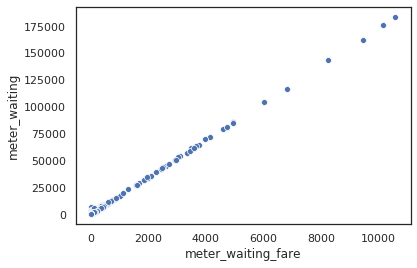

In [57]:
sns.scatterplot(x="meter_waiting_fare", y="meter_waiting",data=train)

fare per time

In [58]:
train[["meter_waiting","meter_waiting_fare"]]

,meter_waiting,meter_waiting_fare
0,56.0,0.0000
1,47.0,0.0000
2,80.0,0.0000
3,271.0,15.6638
4,182.0,0.0000
...,...,...
16959,93.0,5.4219
16960,428.0,0.0000
16961,9.0,0.0000
16962,115.0,0.0000


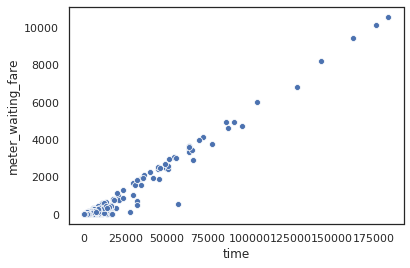

In [59]:
sns.scatterplot(y="meter_waiting_fare", x="time",data=train)

In [60]:
train[((train['time'] < 100)   &  (train['meter_waiting_fare'] > 10000))]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,time,distance


In [61]:
# dataset["fare"] = dataset["fare"].fillna(dataset["fare"].median())
# dataset["additional_fare"] = dataset["additional_fare"].fillna(dataset["additional_fare"].median())
# dataset["duration"] = dataset["duration"].fillna(dataset["duration"].median())
# dataset["meter_waiting"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
# dataset["meter_waiting_fare"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
# dataset["meter_waiting_till_pickup"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())

In [62]:
# dataset = dataset.fillna(np.nan)

# # Check for Null values
# dataset.isnull().sum()

In [63]:
# train['distance'] = np.sqrt((abs(train['pick_lat']- train['drop_lat'])**2) + (abs(train['pick_lon']- train['drop_lon'])**2))

In [64]:
train = train[train.distance<0.6]

In [65]:
train.shape

(16943, 20)

In [66]:
# train = train.drop(['distance'],axis='columns')

In [67]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,difference,travel_time,time,distance
count,1.694300e+04,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000,16943.000000
mean,2.014689e+08,12.895414,1566.800626,486.671723,23.902902,106.589978,6.965220,79.998070,6.965898,79.999202,301.817022,1567.401287,1080.128903,1566.956973,0.040709
std,7.453629e+06,12.243374,4090.000161,3778.631256,218.375993,127.146513,0.210764,0.242912,0.211328,0.243048,375.485568,4090.011401,1053.068859,4089.969108,0.040630
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,79.818400,0.000000,0.000000,0.000000,22.000000,0.000000
25%,1.947362e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.864825,79.870500,6.865580,79.870100,125.535000,540.000000,446.000000,548.000000,0.013411
50%,2.013923e+08,10.500000,1009.000000,123.000000,0.115600,73.000000,6.913970,79.898600,6.915910,79.899000,210.890000,1020.000000,812.000000,1010.000000,0.029033
75%,2.083246e+08,10.500000,1799.500000,350.000000,14.228777,144.000000,7.042820,79.956350,7.046560,79.960000,365.295000,1800.000000,1401.500000,1799.500000,0.055444
max,2.138173e+08,111.000000,183996.000000,183756.000000,10591.618800,2368.000000,8.051010,81.009600,8.064930,81.009700,13350.320000,184020.000000,26061.000000,183996.000000,0.568757


In [68]:
# train["pickup"] = pd.to_datetime(train["pickup_time"])
# train["drop"] = pd.to_datetime(train["drop_time"])
# train ['difference'] = train["drop"] - train["pickup"]
# train ['difference'] = train ['difference']/np.timedelta64(1,'s')
# # train_df['duration'] = train_df['duration'].fillna(train_df ['difference'])
# train['travel_time'] = train['duration'] - train['meter_waiting']

# #train_df['duration'] = train_df ['difference']
# # train['duration'] = np.where(abs(train['duration']-train['difference']) > 120, train['difference'], train['duration'])


In [69]:
# train = train[train.travel_time>=0]

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16943 entries, 0 to 16963
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tripid                     16943 non-null  int64         
 1   additional_fare            16943 non-null  float64       
 2   duration                   16943 non-null  float64       
 3   meter_waiting              16943 non-null  float64       
 4   meter_waiting_fare         16943 non-null  float64       
 5   meter_waiting_till_pickup  16943 non-null  float64       
 6   pickup_time                16943 non-null  object        
 7   drop_time                  16943 non-null  object        
 8   pick_lat                   16943 non-null  float64       
 9   pick_lon                   16943 non-null  float64       
 10  drop_lat                   16943 non-null  float64       
 11  drop_lon                   16943 non-null  float64       
 12  fare

In [71]:
X= train.drop(['pick_lat','drop_lat','pick_lon','drop_lon', 'pickup','drop','difference','pickup_time','drop_time'],axis='columns')

In [72]:
X.shape

(16943, 11)

In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16943 entries, 0 to 16963
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     16943 non-null  int64  
 1   additional_fare            16943 non-null  float64
 2   duration                   16943 non-null  float64
 3   meter_waiting              16943 non-null  float64
 4   meter_waiting_fare         16943 non-null  float64
 5   meter_waiting_till_pickup  16943 non-null  float64
 6   fare                       16943 non-null  float64
 7   label                      16943 non-null  object 
 8   travel_time                16943 non-null  float64
 9   time                       16943 non-null  float64
 10  distance                   16943 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.6+ MB


In [74]:
train = train.drop(['pickup','drop','difference','travel_time','distance','time'],axis='columns')

In [75]:
train.shape

(16943, 14)

In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16943 entries, 0 to 16963
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     16943 non-null  int64  
 1   additional_fare            16943 non-null  float64
 2   duration                   16943 non-null  float64
 3   meter_waiting              16943 non-null  float64
 4   meter_waiting_fare         16943 non-null  float64
 5   meter_waiting_till_pickup  16943 non-null  float64
 6   pickup_time                16943 non-null  object 
 7   drop_time                  16943 non-null  object 
 8   pick_lat                   16943 non-null  float64
 9   pick_lon                   16943 non-null  float64
 10  drop_lat                   16943 non-null  float64
 11  drop_lon                   16943 non-null  float64
 12  fare                       16943 non-null  float64
 13  label                      16943 non-null  obj

In [77]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [78]:
dataset.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct


In [79]:
dataset.drop(labels = ["tripid"], axis = 1, inplace = True)

In [80]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [81]:
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     #all_data[feat] += 1
#     dataset[feat] = boxcox1p(dataset[feat], lam)

In [82]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [83]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct


In [84]:
# dataset["time"]=(pd.to_datetime(dataset.drop_time)-pd.to_datetime(dataset.pickup_time)).dt.total_seconds()

In [85]:
# dataset["w_time"]=dataset['duration']-dataset['meter_waiting']

In [86]:
len(train)

16943

In [87]:
len(test)

8576

In [88]:
len(dataset)

25519

In [89]:
a=dataset[:len(train)].reset_index(drop=True)

In [90]:
a

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
16939,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
16940,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct
16941,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,correct


In [91]:
# a[a["w_time"]<0]

In [92]:
dataset["pickup"] = pd.to_datetime(dataset["pickup_time"])
dataset["drop"] = pd.to_datetime(dataset["drop_time"])
dataset ['difference'] = dataset["drop"] - dataset["pickup"]
dataset ['difference'] = dataset ['difference']/np.timedelta64(1,'s')
# train_df['duration'] = train_df['duration'].fillna(train_df ['difference'])
dataset['travel_time'] = dataset['duration'] - dataset['meter_waiting']

#train_df['duration'] = train_df ['difference']
dataset['duration'] = np.where(abs(dataset['duration']-dataset['difference']) > 120, dataset['difference'], dataset['duration'])


In [93]:
# train = train.drop(train[train['w_time']<0].index, axis = 0).reset_index(drop=True)

In [94]:
# dataset[["drop_time","pickup_time","time"]].head(5)

In [95]:
# dataset['pickup_month'] = pd.to_datetime(dataset.pickup_time).dt.month
# dataset['pickup_day'] = pd.to_datetime(dataset.pickup_time).dt.day
# dataset['pickup_hour'] = pd.to_datetime(dataset.pickup_time).dt.hour
# dataset['pickup_dayofweek'] = pd.to_datetime(dataset.pickup_time).dt.dayofweek
# dataset['pickup_year']=pd.to_datetime(dataset.pickup_time).dt.year
# dataset[["drop_time","pickup_time","pickup_month",'pickup_day','pickup_hour','pickup_dayofweek','pickup_year']]

In [96]:
# g = sns.FacetGrid(dataset, col='pickup_month')
# g = g.map(sns.distplot, "fare")

In [97]:
# dataset.drop(labels = ["pickup_time"], axis = 1, inplace = True)
# dataset.drop(labels = ["drop_time"], axis = 1, inplace = True)
# dataset.drop(labels = ["time"], axis = 1, inplace = True)

In [98]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,2019-11-01 00:20:00,2019-11-01 00:34:00,840.0,778.0
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,2019-11-01 00:56:00,2019-11-01 01:09:00,780.0,744.0
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,2019-11-01 01:08:00,2019-11-01 01:26:00,1080.0,1007.0
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,2019-11-01 02:27:00,2019-11-01 02:37:00,600.0,327.0
4,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,2019-11-01 05:38:00,2019-11-01 06:35:00,3420.0,3225.0


In [99]:
dataset.shape

(25519, 17)

In [100]:
# dataset[(((dataset['time']-100) < dataset['duration']) &  (dataset['duration'] < (dataset['time']+100)))].shape

In [101]:
# dataset[(((dataset['time']-100) > dataset['duration']) |  (dataset['duration'] > (dataset['time']+100)))]

In [102]:
# a=dataset[(((dataset['time']-100) > dataset['duration']) |  (dataset['duration'] > (dataset['time']+100)))].index

In [103]:
# a

In [104]:
# dataset.loc[a]

In [105]:
# dataset = dataset.drop(['pickup','drop','difference'],axis='columns')

In [106]:
# dataset.loc[a,'duration']=dataset.loc[a,'time']

In [107]:
# dataset.loc[a]

In [108]:
# dataset[(((dataset['time']-100) > dataset['duration']) |  (dataset['duration'] > (dataset['time']+100)))]

**distance**

In [109]:
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [110]:
dataset['trip_distance']=dataset.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)

In [111]:
# sns.kdeplot(dataset['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

In [112]:
dataset['distance'] = np.sqrt((abs(dataset['pick_lat']- dataset['drop_lat'])**2) + (abs(dataset['pick_lon']- dataset['drop_lon'])**2))

In [113]:
# sns.kdeplot(np.log(dataset['distance'].values)).set_title("Distribution of Trip Distance (log scale)")

In [114]:
# sns.scatterplot(x="distance", y="fare",data=dataset)

In [115]:
# sns.scatterplot(x="trip_distance", y="fare",data=dataset)

In [116]:
dataset[dataset['fare']==0].shape

(16, 19)

In [117]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,trip_distance,distance
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,2019-11-01 00:20:00,2019-11-01 00:34:00,840.0,778.0,3.164501,0.045869
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,2019-11-01 00:56:00,2019-11-01 01:09:00,780.0,744.0,1.968540,0.028500
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,2019-11-01 01:08:00,2019-11-01 01:26:00,1080.0,1007.0,3.917991,0.057019
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,2019-11-01 02:27:00,2019-11-01 02:37:00,600.0,327.0,0.535588,0.007806
4,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,2019-11-01 05:38:00,2019-11-01 06:35:00,3420.0,3225.0,15.041557,0.217734


In [118]:
dataset[dataset.distance > 0.6]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,trip_distance,distance


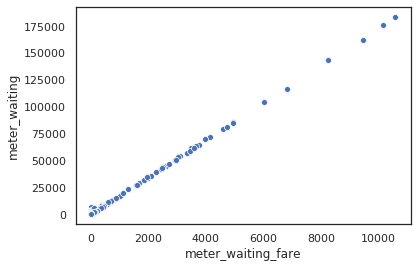

In [119]:
sns.scatterplot(x="meter_waiting_fare", y="meter_waiting",data=train)

In [120]:
b=dataset[((dataset['meter_waiting_fare'] != 0) & (dataset['meter_waiting'] != 0))]

In [121]:
b.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,trip_distance,distance
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,2019-11-01 02:27:00,2019-11-01 02:37:00,600.0,327.0,0.535588,0.007806
6,10.5,1333.0,295.0,17.1985,212.0,11/1/2019 6:50,11/1/2019 7:12,6.90760,79.9524,6.90634,79.9042,318.05,correct,2019-11-01 06:50:00,2019-11-01 07:12:00,1320.0,1038.0,3.307275,0.048216
7,10.5,360.0,80.0,4.6640,3.0,11/1/2019 7:00,11/1/2019 7:06,7.26706,80.6064,7.27422,80.6124,100.32,correct,2019-11-01 07:00:00,2019-11-01 07:06:00,360.0,280.0,0.643307,0.009342
8,10.5,1539.0,588.0,33.9864,43.0,11/1/2019 7:02,11/1/2019 7:28,6.85137,79.9537,6.84779,79.9274,257.89,correct,2019-11-01 07:02:00,2019-11-01 07:28:00,1560.0,951.0,1.821062,0.026543
13,10.5,335.0,10.0,0.5830,17.0,11/1/2019 7:45,11/1/2019 7:51,6.85268,79.8631,6.86560,79.8640,126.87,correct,2019-11-01 07:45:00,2019-11-01 07:51:00,360.0,325.0,0.894818,0.012951


In [122]:
b['waiting_fare_per']=b['meter_waiting_fare']/b['meter_waiting']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
b['waiting_fare_per'].head()

3     0.0578
6     0.0583
7     0.0583
8     0.0578
13    0.0583
Name: waiting_fare_per, dtype: float64

In [124]:
b['waiting_fare_per'].mean()

0.05566547990450998

In [125]:
i=dataset[((dataset['meter_waiting_fare'] == 0) & (dataset['meter_waiting'] > 0))].index

In [126]:
# dataset.loc[i,'meter_waiting_fare']=dataset.loc[i,'meter_waiting']*b['waiting_fare_per'].mean()

In [127]:
dataset.loc[i]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup,drop,difference,travel_time,trip_distance,distance
0,10.5,834.0,56.0,0.0,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,2019-11-01 00:20:00,2019-11-01 00:34:00,840.0,778.0,3.164501,0.045869
1,10.5,791.0,47.0,0.0,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,2019-11-01 00:56:00,2019-11-01 01:09:00,780.0,744.0,1.968540,0.028500
2,10.5,1087.0,80.0,0.0,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,2019-11-01 01:08:00,2019-11-01 01:26:00,1080.0,1007.0,3.917991,0.057019
4,10.5,3407.0,182.0,0.0,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,2019-11-01 05:38:00,2019-11-01 06:35:00,3420.0,3225.0,15.041557,0.217734
5,10.5,1246.0,487.0,0.0,133.0,11/1/2019 6:29,11/1/2019 6:49,6.84371,79.9051,6.85069,79.8624,266.62,correct,2019-11-01 06:29:00,2019-11-01 06:49:00,1200.0,759.0,2.968678,0.043267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25500,10.5,1206.0,201.0,0.0,123.0,3/16/2020 18:12,3/16/2020 18:32,6.90318,79.8522,6.84278,79.8754,299.74,NaN,2020-03-16 18:12:00,2020-03-16 18:32:00,1200.0,1005.0,4.466386,0.064702
25502,10.5,2043.0,74.0,0.0,44.0,3/16/2020 18:33,3/16/2020 19:07,6.86026,79.9063,6.86236,79.9971,430.89,NaN,2020-03-16 18:33:00,2020-03-16 19:07:00,2040.0,1969.0,6.230433,0.090824
25506,10.5,1579.0,30.0,0.0,252.0,3/16/2020 19:21,3/16/2020 19:47,6.88485,79.9022,6.93582,79.8957,267.38,NaN,2020-03-16 19:21:00,2020-03-16 19:47:00,1560.0,1549.0,3.549796,0.051383
25510,10.5,689.0,6.0,0.0,80.0,3/16/2020 20:56,3/16/2020 21:07,7.15432,79.8719,7.20299,79.8605,268.95,NaN,2020-03-16 20:56:00,2020-03-16 21:07:00,660.0,683.0,3.452385,0.049987


In [128]:
dataset['n_fare']=dataset['fare']- (dataset['additional_fare']-dataset['meter_waiting_fare'])

In [129]:
dataset['n_fare'].describe()

count    25519.000000
mean       310.820601
std        621.252165
min        -28.336359
25%        118.275000
50%        205.330000
75%        361.860600
max      52594.191800
Name: n_fare, dtype: float64

In [130]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25519 entries, 0 to 25518
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   additional_fare            25519 non-null  float64       
 1   duration                   25519 non-null  float64       
 2   meter_waiting              25519 non-null  float64       
 3   meter_waiting_fare         25519 non-null  float64       
 4   meter_waiting_till_pickup  25519 non-null  float64       
 5   pickup_time                25519 non-null  object        
 6   drop_time                  25519 non-null  object        
 7   pick_lat                   25519 non-null  float64       
 8   pick_lon                   25519 non-null  float64       
 9   drop_lat                   25519 non-null  float64       
 10  drop_lon                   25519 non-null  float64       
 11  fare                       25519 non-null  float64       
 12  labe

In [131]:
dataset = dataset.drop(['pick_lat','pick_lon','drop_lat','drop_lon','n_fare','trip_distance','pickup','drop','difference','pickup_time','drop_time'],axis='columns')

In [132]:
dataset.shape

(25519, 9)

In [133]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25519 entries, 0 to 25518
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            25519 non-null  float64
 1   duration                   25519 non-null  float64
 2   meter_waiting              25519 non-null  float64
 3   meter_waiting_fare         25519 non-null  float64
 4   meter_waiting_till_pickup  25519 non-null  float64
 5   fare                       25519 non-null  float64
 6   label                      16943 non-null  object 
 7   travel_time                25519 non-null  float64
 8   distance                   25519 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.8+ MB


In [134]:
# dataset['travel_time'] = dataset['duration'] - dataset['meter_waiting']

In [135]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["label"],axis = 1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [136]:
test.shape

(8576, 8)

In [137]:
train.shape

(16943, 9)

In [138]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 16943 to 25518
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            8576 non-null   float64
 1   duration                   8576 non-null   float64
 2   meter_waiting              8576 non-null   float64
 3   meter_waiting_fare         8576 non-null   float64
 4   meter_waiting_till_pickup  8576 non-null   float64
 5   fare                       8576 non-null   float64
 6   travel_time                8576 non-null   float64
 7   distance                   8576 non-null   float64
dtypes: float64(8)
memory usage: 536.1 KB


In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16943 non-null  float64
 1   duration                   16943 non-null  float64
 2   meter_waiting              16943 non-null  float64
 3   meter_waiting_fare         16943 non-null  float64
 4   meter_waiting_till_pickup  16943 non-null  float64
 5   fare                       16943 non-null  float64
 6   label                      16943 non-null  object 
 7   travel_time                16943 non-null  float64
 8   distance                   16943 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.2+ MB


In [140]:
# train = train.drop(train[train['w_time']<0].index, axis = 0).reset_index(drop=True)

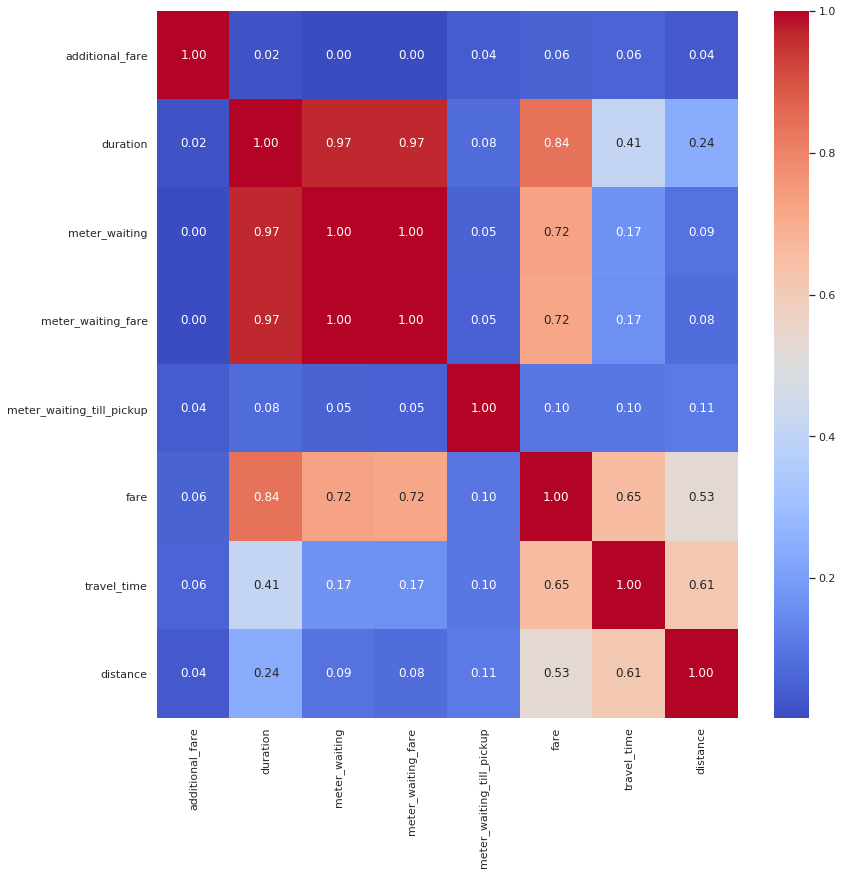

In [141]:
plt.figure(figsize=[13,13])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [142]:
# sns.scatterplot(x="time", y="duration",data=dataset)

duration is filled with time 

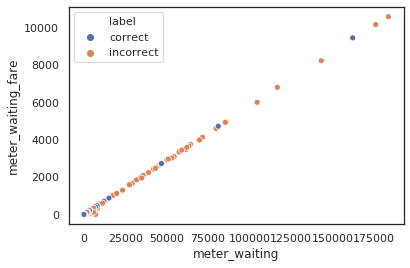

In [143]:
sns.scatterplot(x="meter_waiting", y="meter_waiting_fare",hue="label",data=dataset)

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16943 non-null  float64
 1   duration                   16943 non-null  float64
 2   meter_waiting              16943 non-null  float64
 3   meter_waiting_fare         16943 non-null  float64
 4   meter_waiting_till_pickup  16943 non-null  float64
 5   fare                       16943 non-null  float64
 6   label                      16943 non-null  object 
 7   travel_time                16943 non-null  float64
 8   distance                   16943 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.2+ MB


In [145]:
train["label"] = train["label"].map({"correct": 1, "incorrect":0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16943 non-null  float64
 1   duration                   16943 non-null  float64
 2   meter_waiting              16943 non-null  float64
 3   meter_waiting_fare         16943 non-null  float64
 4   meter_waiting_till_pickup  16943 non-null  float64
 5   fare                       16943 non-null  float64
 6   label                      16943 non-null  int64  
 7   travel_time                16943 non-null  float64
 8   distance                   16943 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [147]:
train.isnull().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
fare                         0
label                        0
travel_time                  0
distance                     0
dtype: int64

In [148]:
# dataset.drop(labels = ["time"], axis = 1, inplace = True)

In [149]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1)

In [150]:
X_train.info()
X_train.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16943 entries, 0 to 16942
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16943 non-null  float64
 1   duration                   16943 non-null  float64
 2   meter_waiting              16943 non-null  float64
 3   meter_waiting_fare         16943 non-null  float64
 4   meter_waiting_till_pickup  16943 non-null  float64
 5   fare                       16943 non-null  float64
 6   travel_time                16943 non-null  float64
 7   distance                   16943 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


(16943, 8)

In [151]:
Y_train.shape

(16943,)

In [152]:
test.shape

(8576, 8)

In [153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

In [154]:
train.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,travel_time,distance
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,778.0,0.045869
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,744.0,0.028500
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1007.0,0.057019
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,327.0,0.007806
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,3225.0,0.217734


In [155]:
dataset['additional_fare'].unique()

array([ 10.5,   5. ,  60.5,  40.5,  35. ,   0. ,  55. , 110.5, 111. ,
        21. ,  20.5,  70.5,  11. ,  80.5,  75. , 105. ,  81. ,  10. ,
        30.5,  25. ,  91.5,  85.5,  80. ,  61. , 160.5])

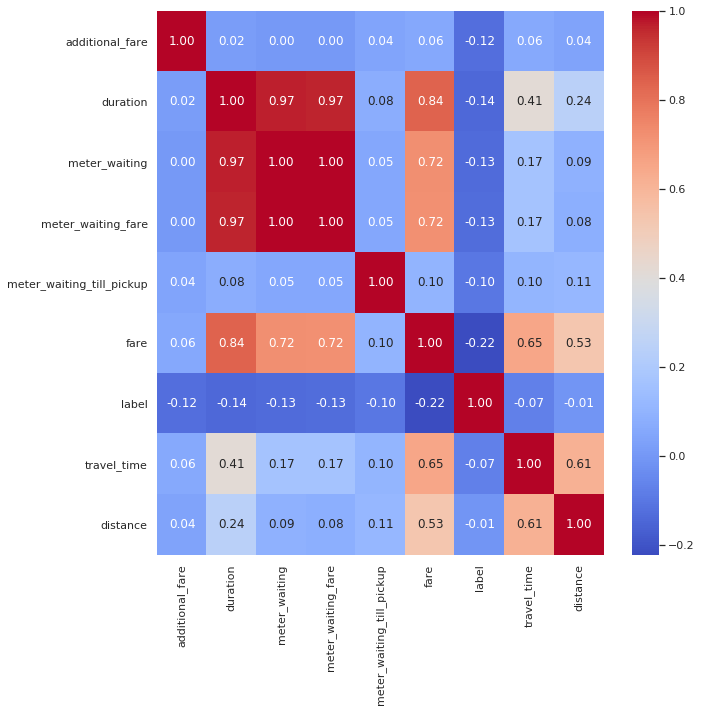

In [156]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [157]:
X_train.shape

(16943, 8)

In [158]:
Y_train.shape

(16943,)

In [159]:
kfold = StratifiedKFold(n_splits=10)

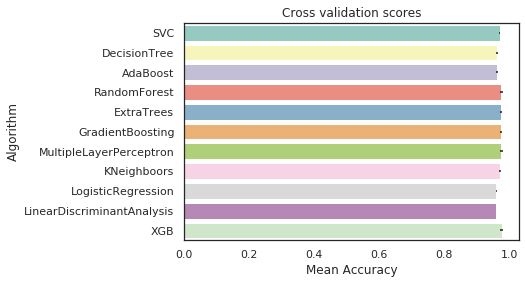

In [160]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "f1", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGB"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [161]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.970115,0.002324,SVC
1,0.961600,0.003524,DecisionTree
2,0.961906,0.004137,AdaBoost
3,0.975292,0.003858,RandomForest
4,0.974648,0.003507,ExtraTrees
5,0.972893,0.002796,GradientBoosting
6,0.975495,0.003266,MultipleLayerPerceptron
7,0.972189,0.003179,KNeighboors
8,0.958906,0.001397,LogisticRegression
9,0.958549,0.001376,LinearDiscriminantAnalysis


In [174]:
# XGB Parameters tunning 
XGB = XGBClassifier()

## Search grid for optimal parameters
xgbc_param_grid = {
   "learning_rate"    : [0.15] , #[0.15]
   "max_depth"        : [6],    #[6]
   "n_estimators"     : [100,120],    #[100]
    "min_child_weight" : [1], #[2]
   "gamma"            : [0.15] #[0.15]
    }


gsXGB = GridSearchCV(XGB,param_grid = xgbc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train,Y_train)

XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   15.6s finished


0.9762622601835622

In [175]:
gsXGB.best_params_

{'gamma': 0.15,
 'learning_rate': 0.15,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 120}

In [177]:
test_Survived = pd.Series(XGB_best.predict(test), name="prediction")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting_new.csv",index=False)

In [178]:
results.head(5)

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1


In [179]:
results['prediction'].value_counts()

1    8181
0     395
Name: prediction, dtype: int64